# Integrating human and mouse caudate snATAC-seq

Notes on linked peaks notes: 
- human peak w/ mouse ortholog intersecting human ortholog of mouse peak
- call ties w/ multiple peak matches using nearest summits
- count matrix comes from linked peaks 1-1 in human and mouse 

Notes on integration:
- perform integration with about same number of cells in each group
- here selected representative human and mouse subject
- predefine the features during anchor finding step

In [1]:
PROJDIR=file.path('../../../data/raw_data/mouse-human_peak_orthologs')

#######################################
### set up libraries and functions ####
ss <- function(x, pattern, slot = 1, ...) { 
  sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F, repr.plot.width=14, repr.plot.height=6)
suppressMessages(library(Signac)); suppressMessages(library(Seurat))

source('../hal_scripts/narrowPeakFunctions.R')
parallel::detectCores()

[1] 64

In [2]:
# # set up future for parallelization
library(future)
library(future.apply)
plan("multiprocess")
options(future.globals.maxSize = 25 * 1024^3)

# 1) visualize unintegrated species clusters

In [3]:
## load the seurat object
saveRDS_fn = file.path(PROJDIR, 'rdas', 'linkOrthologMatrixSeurat.rds')
obj_seurat = readRDS(file = saveRDS_fn)

In [4]:
##  TF-IDF, SVD, and UMAP already performed on 'peaks' matrix
obj_seurat
obj_seurat@meta.data$log10nFrags = log10(obj_seurat@meta.data$nFrags)

An object of class Seurat 
36983 features across 48680 samples within 1 assay 
Active assay: peaks (36983 features, 36983 variable features)
 2 dimensional reductions calculated: lsi, umap

In [5]:
## subset to just 2 representative sample per species ###
# cells = WhichCells(obj_seurat,expression = Sample %in% 
#                      c('14_1018.CAUD', 'CEMBA171219_4D'))
# obj_seurat = subset(obj_seurat, cells = cells)

## show cells per Species
table(obj_seurat@meta.data$Sample)

## show cell clusters per sample
table(obj_seurat@meta.data$Clusters2, obj_seurat@meta.data$Sample)


  06_0615.CAUD   09_1589.CAUD   14_1018.CAUD CEMBA171214_4D CEMBA171219_4D 
         10199           8672           7443           5082           5306 
CEMBA180813_5E CEMBA180820_5E 
          6283           5695 

             
              06_0615.CAUD 09_1589.CAUD 14_1018.CAUD CEMBA171214_4D
  Astro                436          391          417            412
  Interneuron          281          210          133            406
  Microglia            806          634          278            104
  MSN_D1              1191         1315          650           2669
  MSN_D2              1240         1497          746            194
  MSN_UNK1             378          189           11              0
  MSN_UNK2             389          126           16            758
  Mural                220          164           68             15
  Oligo               4651         3747         4952            380
  OPC                  582          367          160            140
  VLMC                  25           32           12              4
             
              CEMBA171219_4D CEMBA180813_5E CEMBA180820_5E
  Astro                  369            630            537
  Interneuron            451          

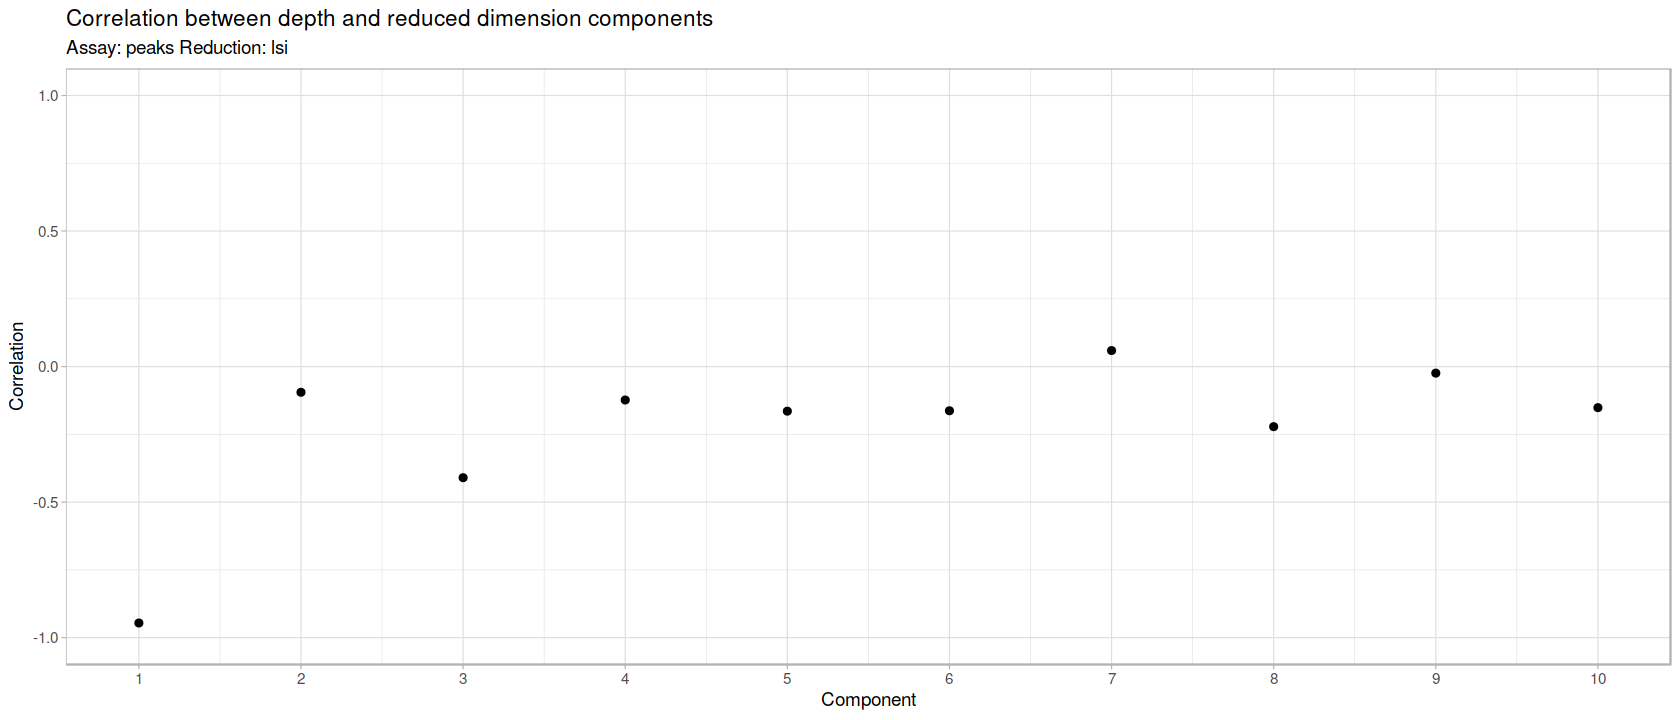

In [6]:
DepthCor(obj_seurat) # drop the first PC, correlated with number fragments

Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."


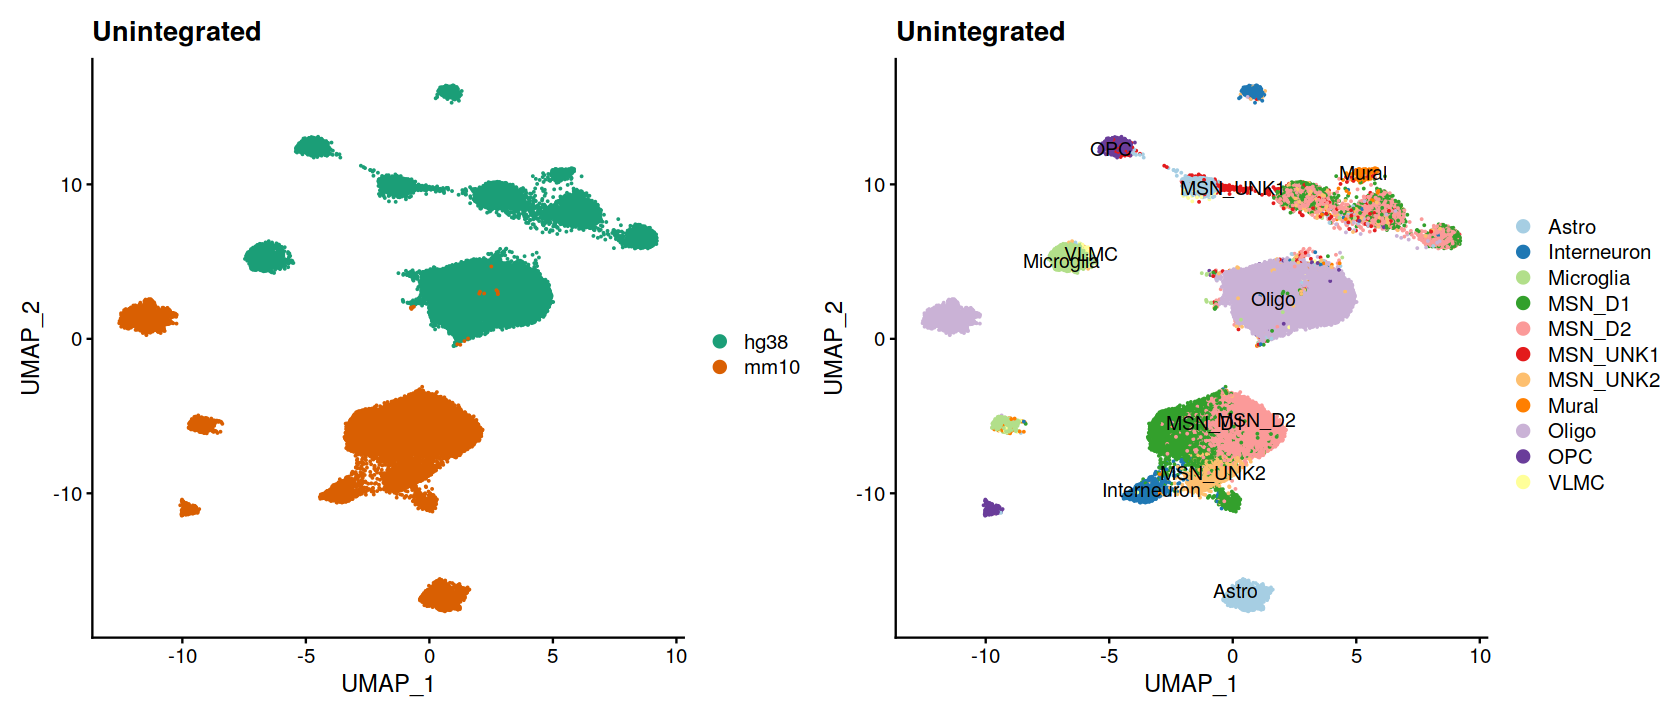

In [7]:
p_unintegrated_species = 
    DimPlot(object = obj_seurat, label = FALSE, group.by = 'Species', cols = 'Dark2') + 
    ggplot2::ggtitle("Unintegrated")

p_unintegrated_clusters2 = 
    DimPlot(object = obj_seurat, label = TRUE, group.by = 'Clusters2', cols = 'Paired') + 
    ggplot2::ggtitle("Unintegrated")

p_unintegrated_species + p_unintegrated_clusters2

# 2) integration with Seurat CCA

In [8]:
## split seurat object up by species
obj_seurat.list = SplitObject(obj_seurat, split.by = 'Sample')
print(names(obj_seurat.list))
obj_seurat.list = lapply(obj_seurat.list, function(x){
  x <- RunTFIDF(x, verbose = FALSE)
 #x <- FindTopFeatures(x, min.cutoff = 'q5')
  x <- RunSVD(x, verbose = FALSE)
})

# features <- SelectIntegrationFeatures(object.list = obj_seurat.list, nfeatures = 10000)
features <- rownames(obj_seurat)

[1] "09_1589.CAUD"   "14_1018.CAUD"   "06_0615.CAUD"   "CEMBA180813_5E"
[5] "CEMBA171219_4D" "CEMBA171214_4D" "CEMBA180820_5E"


In [9]:
# using 14_1018.CAUD as reference
ref = which(names(obj_seurat.list) %in% c("14_1018.CAUD")) 

# find integration anchors between species, using all features
anchors <- FindIntegrationAnchors(
    object.list = obj_seurat.list, reduction = 'cca', anchor.features = features,
    reference = c(ref), # using 09_1589.CAUD 14_1018.CAUD as reference
    k.filter = NA, assay = rep('peaks', length(obj_seurat.list)))

gc()

Scaling features for provided objects

Finding anchors between all query and reference datasets

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 21797 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 23420 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 23070 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 20487 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 20030 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 21844 anchors



used       (Mb)    gc trigger (Mb)    max used   (Mb)   
Ncells   11113480   593.6   17062154   911.3   17062154   911.3
Vcells 2032832613 15509.3 4632239106 35341.2 4632231606 35341.2

In [10]:
# integrate data and create a new merged object
integrated <- IntegrateData(anchors, dims = 2:30, preserve.order = TRUE)

# we now have a "corrected" TF-IDF matrix, and can run LSI again on this corrected matrix
integrated <- RunSVD(integrated, n = 30, reduction.name = 'integratedLSI', verbose = FALSE)

Integrating dataset 1 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Integrating dataset 3 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Integrating dataset 4 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Integrating dataset 5 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Integrating dataset 6 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Integrating dataset 7 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
"Adding a command log without an assay associated with it"
Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To u

In [26]:
integrated <- RunUMAP(integrated, dims = 1:30, reduction = 'integratedLSI', verbose = FALSE)

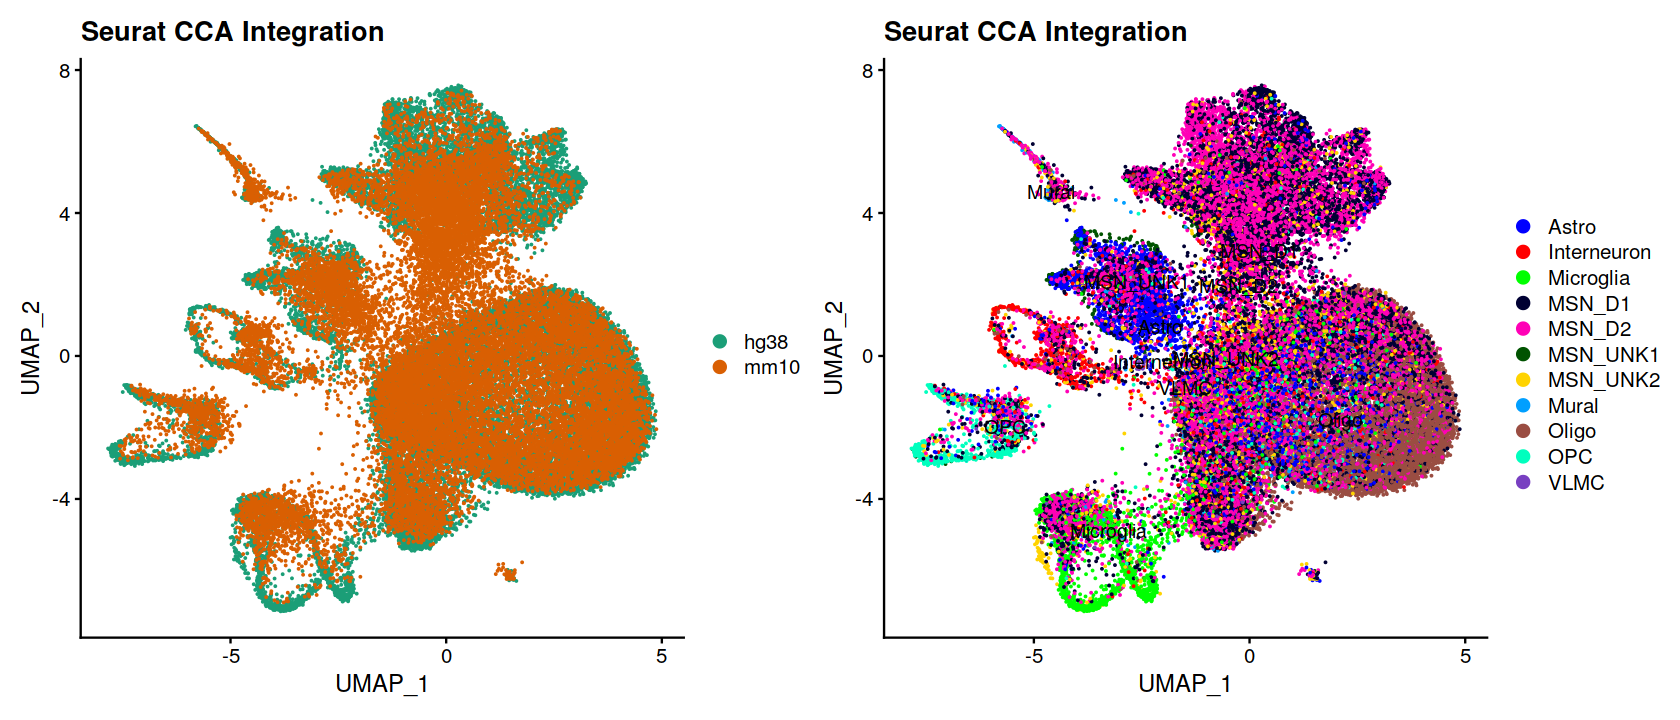

In [27]:
# plot embeddings
integrated = integrated[, sample(seq(ncol(integrated)),ncol(integrated))]
p_seuratIntegration_species = 
    DimPlot(object = integrated, label = FALSE, group.by = 'Species', cols = 'Dark2') +
    ggplot2::ggtitle('Seurat CCA Integration')

p_seuratIntegration_clusters2 = 
    DimPlot(object = integrated, label = TRUE, group.by = 'Clusters2', cols = 'glasbey') +
    ggplot2::ggtitle('Seurat CCA Integration')

p_seuratIntegration_species + p_seuratIntegration_clusters2

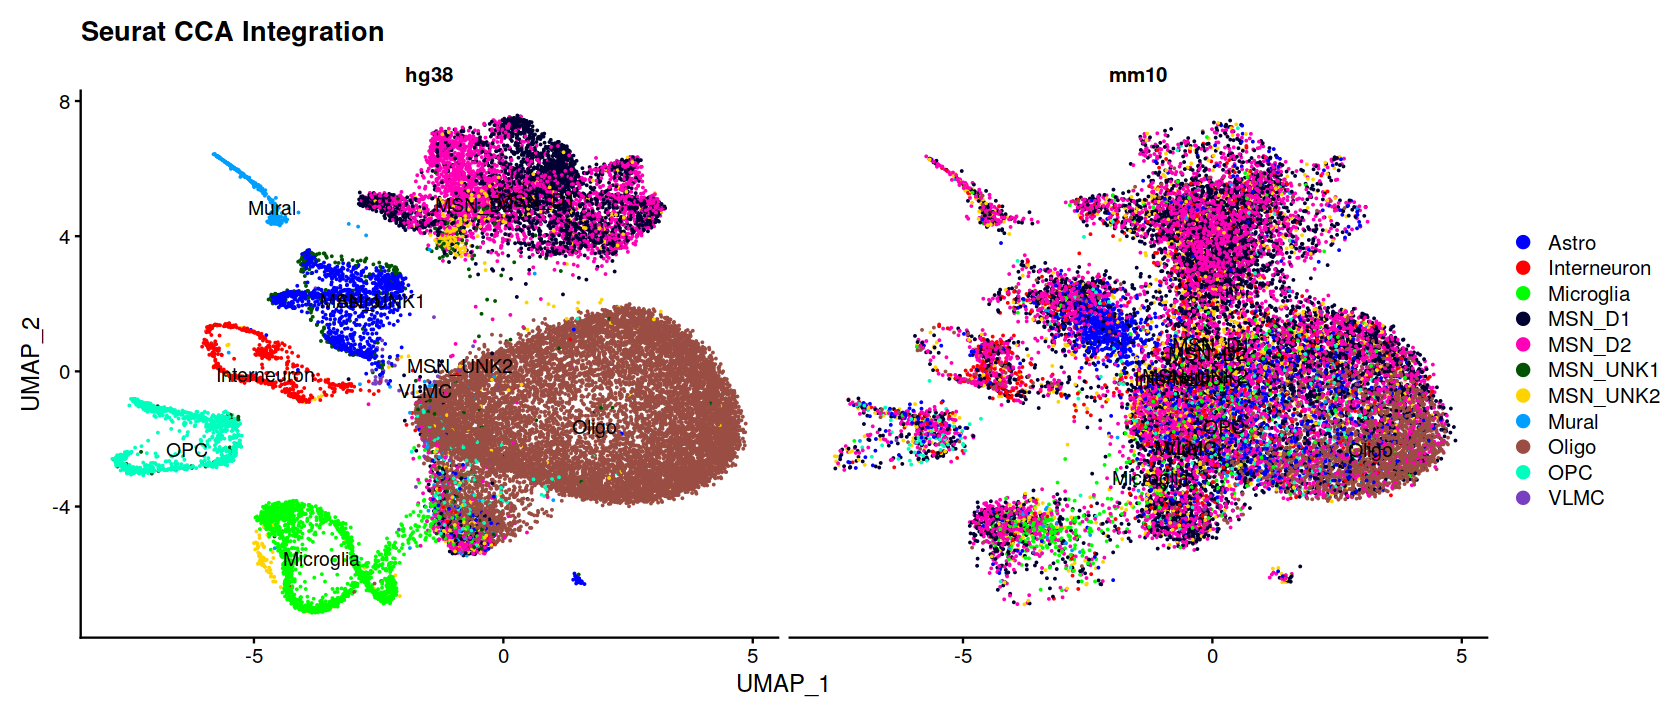

In [28]:
DimPlot(object = integrated, label = TRUE, group.by = 'Clusters2', cols = 'glasbey',split.by = 'Species') +
    ggplot2::ggtitle('Seurat CCA Integration')